<h1 style="font-size:2.0em; font-weight:bold; text-align:center;">Model Training </h1>

Inspired by Ferwerda and Joras (2019), **"Tariffs, Sanctions and the Problem of Trade-Based Money Laundering"** - European Studies on Crime and Criminal Justice, this data science project simulates and detects Trade-Based Money Laundering (TBML) within corporate banking transactions. It focuses on identifying behavioral patterns that emerge during periods of tariff and sanctions-related tensions (e.g., China–U.S. trade conflict).

The dataset spans from **April 2, 2025, to December 31, 2025**, under the assumption that a mid-2025 trade war escalation introduces new tariffs and restrictions, triggering abnormal or suspicious transaction activity.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/CLEAN_nordic_transactions_with_fraud.csv')
data.head().T

,0,1,2,3,4
amount,2.037016e+05,4.276423e+05,4.647175e+05,2.658877e+05,376947.000000
amount.1,-1.449589e-01,7.213699e-01,8.647976e-01,9.561192e-02,0.525252
expected_turnover,1.021012e+06,1.491545e+06,1.967002e+06,1.017836e+06,456226.440000
expected_turnover.1,4.490636e-02,4.993432e-01,9.585360e-01,4.183926e-02,-0.500559
amount_eur,1.768477e+04,3.906301e+04,4.034538e+04,3.564225e+04,32725.407699
...,...,...,...,...,...
is_high_frequency.3,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000
is_split.2,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000
is_split.3,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000
is_fraud,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


**The correlations between the dependent variables.**

Create a histogram of the correlation values and identify those that are most correlated (either positively or negatively).

In [3]:
feature_cols = data.columns.drop('is_fraud')
corr_values = data[feature_cols].corr()

tril_index = np.tril_indices_from(corr_values)

for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

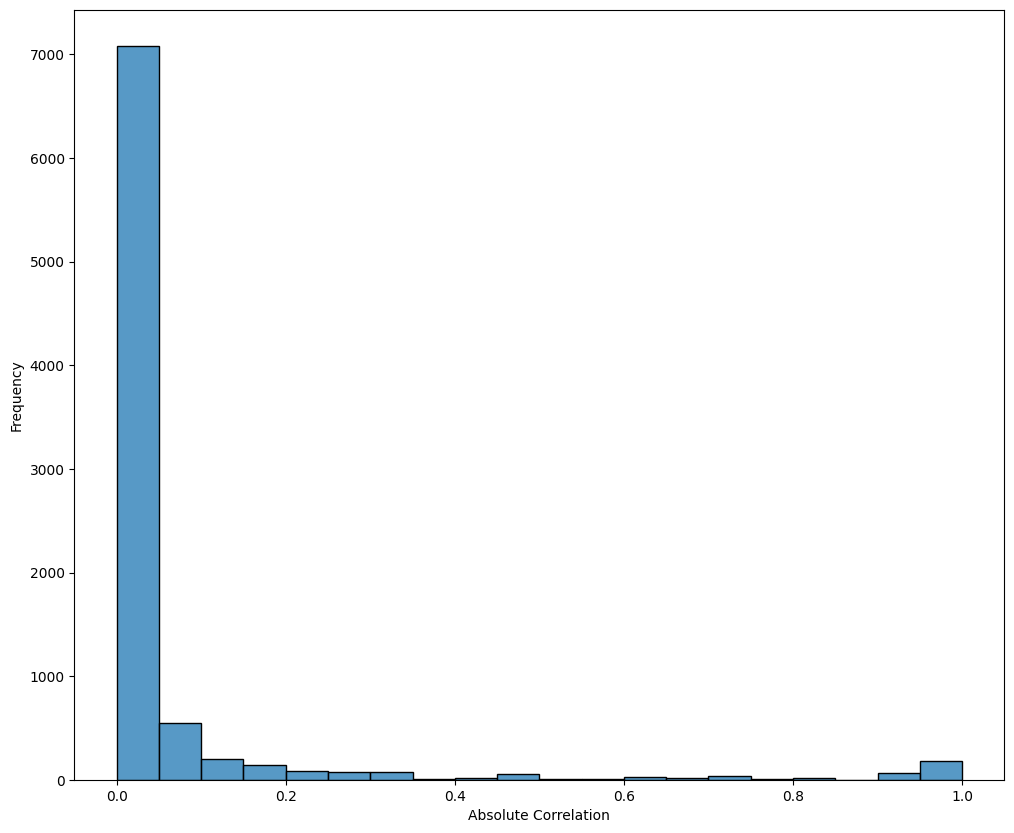

In [4]:
plt.figure(figsize=(12,10))
sns.histplot(corr_values['abs_correlation'], bins=20)
plt.xlabel('Absolute Correlation')
plt.ylabel('Frequency')
plt.show()

In [ ]:
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
8051,expected_turnover.2,expected_turnover.3,1.000000,1.000000
261,expected_turnover,expected_turnover.1,1.000000,1.000000
356,expected_turnover,expected_turnover.3,1.000000,1.000000
483,expected_turnover.1,expected_turnover.2,1.000000,1.000000
225,amount.1,amount.3,1.000000,1.000000
...,...,...,...,...
8273,transaction_day.3,booking_day.3,0.820058,0.820058
998,transaction_day.1,booking_day.3,0.820058,0.820058
4551,counterparty_name_0,counterparty_name_rare_var,-1.000000,1.000000
6816,related_trade_invoice_id_0,related_trade_invoice_id_rare_var,-1.000000,1.000000


when we see something that's so highly correlated, we may want to do feature selection.

## <h2 style="font-size: 1.8em; font-weight: bold;"> Baseline Model Training </h2>

As `is_fraud` is imbalanced, so we use StratifiedShuffleSplit() to maintain the same ratio of predictor classes.

In [ ]:
X = data[feature_cols]
y = data['is_fraud']

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, test_idx in strat_shuf_split.split(X, y):
  X_train = data.loc[train_idx, feature_cols]
  y_train = data.loc[train_idx, 'is_fraud']

  X_test  = data.loc[test_idx, feature_cols]
  y_test  = data.loc[test_idx, 'is_fraud']